In [1]:
import utils as utils
import json
import copy
import torch.nn as nn
import torch
from dataloader.BSD500 import BSD500
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from tqdm import tqdm
import math
from matplotlib import pyplot as plt
from reconstruction_map_mask_perturbed import *
from mri_forward_utils import *

In [2]:
def compute_PSNR(img, imclean, data_range):
    Img = img.data.cpu().numpy().astype(np.float32)
    Iclean = imclean.data.cpu().numpy().astype(np.float32)
    PSNR = compare_psnr(Iclean[0,:,:,:], Img[0,:,:,:], data_range=data_range)
    return PSNR

In [3]:
device = 'cuda:3'
add = '/home/pourya/all_methods_backup/inverse_problems/mri/data/data_sets/singlecoil_acc_4_cf_0.08_noisesd_0.002/pdfs/test_images/file1001191'
x = torch.load(add + '/x.pt').to(device)
y = torch.load(add + '/y.pt').to(device)
mask = torch.load(add + '/mask.pt').to(device)
gt = torch.load(add + '/x_crop.pt').to(device)

In [4]:
from R_network_relax import RNet 
import json, torch

model_name = 'mask_safi' #opts.get('model_name', None)

if model_name is None:
    raise ValueError("Please provide a model_name for the mask model. It is the name of the folder corrsponding to the trained model.")


exp = "exps/sigma15/64_2_7_1e-3_relaxed/"
#exp = "exps/sigma_25_64_4_3_deq_shared/AdpReg_ccvcvx"
path_ckp = exp + "/checkpoints/checkpoint_best_epoch.pth"
path_config = exp + "/config.json"
config = json.load(open(path_config))
ckp = torch.load(path_ckp, map_location={'cuda:0':device,'cuda:1':device,'cuda:2':device,'cuda:3':device})

model = RNet(config['model_params'])
model.to(device)
model.load_state_dict(ckp['state_dict'])
model.eval()

model.W1.W1.weight.data = model.zeromean(model.W1.W1.weight)
for i, _ in enumerate(model.W1.W1s): 
    model.W1.W1s[i].weight.data = model.zeromean(model.W1.W1s[i].weight)


model.eigenimage = model.eigenimage.to(device)
lip, model.eigenimage = model.W1.cal_lip(model.eigenimage, 200)
model.alpha = 1 / lip

In [5]:
H = OpMRI_singlecoil_forward(mask, device)
Ht = OpMRI_singlecoil_adjoint(mask, device)
with torch.no_grad():
    c_k = prox_Recon(y, model, lmbd=1.720804035659816e-05, H=H, Ht=Ht, op_norm=1, x_gt=gt, crop=True, max_iter=300, perturb=False)

torch.save(c_k, 'perturb_inv/sol_no_perturb_safi.pt')

psnr: 34.24 | ssim: 0.8372 | res: 9.76e-04:  14%|█▎        | 41/300 [00:08<00:53,  4.82it/s]


perturbed PSNR (sol no mask, init mm): tensor(34.2424, device='cuda:3')


psnr: 35.93 | ssim: 0.8672 | res: 3.94e-04:  26%|██▌       | 77/300 [00:19<00:56,  3.91it/s]
psnr: 36.30 | ssim: 0.8712 | res: 1.58e-04:  32%|███▏      | 95/300 [00:33<01:12,  2.84it/s]
psnr: 36.38 | ssim: 0.8720 | res: 6.30e-05:  27%|██▋       | 82/300 [00:40<01:46,  2.05it/s]
psnr: 36.41 | ssim: 0.8723 | res: 2.49e-05:  31%|███       | 92/300 [01:09<02:37,  1.32it/s]
psnr: 36.43 | ssim: 0.8724 | res: 9.96e-06:  32%|███▏      | 96/300 [01:51<03:57,  1.16s/it]
psnr: 36.43 | ssim: 0.8725 | res: 9.85e-06:  24%|██▎       | 71/300 [01:16<04:05,  1.07s/it]
psnr: 36.43 | ssim: 0.8725 | res: 9.61e-06:  23%|██▎       | 69/300 [01:13<04:05,  1.06s/it]
psnr: 36.43 | ssim: 0.8725 | res: 9.57e-06:  23%|██▎       | 68/300 [01:11<04:05,  1.06s/it]
psnr: 36.44 | ssim: 0.8725 | res: 9.83e-06:  22%|██▏       | 67/300 [01:10<04:05,  1.05s/it]

final


In [6]:
H = OpMRI_singlecoil_forward(mask, device)
Ht = OpMRI_singlecoil_adjoint(mask, device)
with torch.no_grad():
    c_k = prox_Recon(y, model, lmbd=1.720804035659816e-05, H=H, Ht=Ht, op_norm=1, x_gt=gt, crop=True, max_iter=300, perturb=True, perturb_seed=42)

torch.save(c_k, 'perturb_inv/sol_perturb_42_safi.pt')

psnr: 34.24 | ssim: 0.8372 | res: 9.76e-04:  14%|█▎        | 41/300 [00:08<00:53,  4.80it/s]


perturbed PSNR (sol no mask, init mm): 24.16082763671875


psnr: 35.10 | ssim: 0.8540 | res: 3.91e-04:  29%|██▉       | 88/300 [00:22<00:53,  3.95it/s]
psnr: 36.17 | ssim: 0.8691 | res: 1.57e-04:  37%|███▋      | 110/300 [00:39<01:08,  2.78it/s]
psnr: 36.35 | ssim: 0.8715 | res: 6.27e-05:  31%|███       | 92/300 [00:45<01:43,  2.01it/s]
psnr: 36.41 | ssim: 0.8722 | res: 2.47e-05:  32%|███▏      | 95/300 [01:12<02:35,  1.31it/s]
psnr: 36.42 | ssim: 0.8724 | res: 9.81e-06:  35%|███▍      | 104/300 [02:03<03:52,  1.18s/it]
psnr: 36.43 | ssim: 0.8724 | res: 9.74e-06:  24%|██▍       | 73/300 [01:18<04:05,  1.08s/it]
psnr: 36.43 | ssim: 0.8725 | res: 9.91e-06:  23%|██▎       | 69/300 [01:13<04:05,  1.06s/it]
psnr: 36.43 | ssim: 0.8725 | res: 9.73e-06:  23%|██▎       | 68/300 [01:11<04:05,  1.06s/it]
psnr: 36.43 | ssim: 0.8725 | res: 9.87e-06:  22%|██▏       | 67/300 [01:10<04:05,  1.05s/it]

final


In [7]:
H = OpMRI_singlecoil_forward(mask, device)
Ht = OpMRI_singlecoil_adjoint(mask, device)
with torch.no_grad():
    c_k = prox_Recon(y, model, lmbd=1.720804035659816e-05, H=H, Ht=Ht, op_norm=1, x_gt=gt, crop=True, max_iter=300, perturb=False, perturb_seed=42, start_noise=True)

torch.save(c_k, 'perturb_inv/start_with_noise_safi.pt')

psnr: 34.24 | ssim: 0.8372 | res: 9.76e-04:  14%|█▎        | 41/300 [00:08<00:53,  4.81it/s]


perturbed PSNR (sol no mask, init mm): -0.15284794569015503


psnr: 34.17 | ssim: 0.8418 | res: 3.98e-04:  41%|████      | 122/300 [00:34<00:50,  3.54it/s]
psnr: 36.08 | ssim: 0.8680 | res: 1.55e-04:  42%|████▏     | 126/300 [00:46<01:03,  2.73it/s]
psnr: 36.33 | ssim: 0.8714 | res: 6.18e-05:  32%|███▏      | 97/300 [00:48<01:42,  1.99it/s]
psnr: 36.40 | ssim: 0.8721 | res: 2.50e-05:  33%|███▎      | 100/300 [01:16<02:33,  1.30it/s]
psnr: 36.42 | ssim: 0.8724 | res: 9.90e-06:  36%|███▌      | 107/300 [02:07<03:49,  1.19s/it]
psnr: 36.43 | ssim: 0.8724 | res: 9.99e-06:  25%|██▍       | 74/300 [01:20<04:05,  1.08s/it]
psnr: 36.43 | ssim: 0.8725 | res: 9.93e-06:  23%|██▎       | 70/300 [01:14<04:05,  1.07s/it]
psnr: 36.43 | ssim: 0.8725 | res: 9.97e-06:  23%|██▎       | 68/300 [01:11<04:05,  1.06s/it]
psnr: 36.43 | ssim: 0.8725 | res: 9.99e-06:  22%|██▏       | 67/300 [01:10<04:04,  1.05s/it]

final


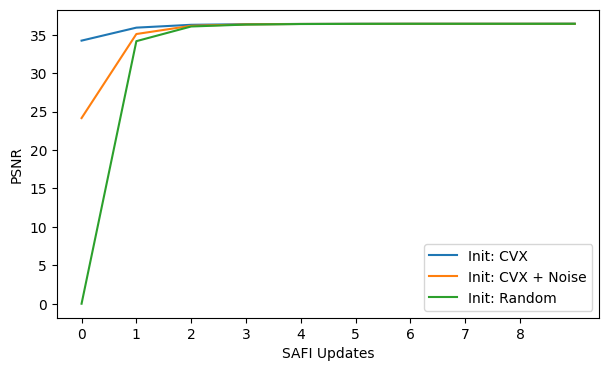

In [8]:
from matplotlib import pyplot as plt
import numpy as np
psnrs_cvx = [34.24, 35.93, 36.30, 36.38, 36.41, 36.43, 36.43, 36.43, 36.43, 36.44]
psnrs_perturb = [24.16, 35.10, 36.17, 36.35, 36.41, 36.42, 36.43, 36.43, 36.43, 36.43]
psnrs_noise = [0, 34.17, 36.08, 36.33, 36.40, 36.42, 36.43, 36.43, 36.43, 36.43]

plt.figure(figsize=(7, 4))
plt.plot(psnrs_cvx, label='Init: CVX')
plt.plot(psnrs_perturb, label='Init: CVX + Noise')
plt.plot(psnrs_noise, label='Init: Random')
plt.legend()
plt.xlabel('SAFI Updates')
plt.ylabel('PSNR')
plt.xticks(np.arange(0, 9, 1.0))
plt.savefig('fig_data/safi_init.pdf', bbox_inches="tight")
plt.show()